* Compile, Train and Save the models here

* 1. Preprocessing

In [1]:
import numpy as np  # linear algebra
import pandas as pd  # CSV file
import config
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def Scale_and_PCALDA(path):

    data = pd.read_csv(path)
    num_columns = data.shape[1]
    print(f"Num of Columns is {num_columns}")
    X = np.array(data.iloc[:,0:num_columns-1])
    y = np.array(data.iloc[:,num_columns-1])
    # print(len(X[0]))
    # print(y[0])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # X shape: (n_samples, 12)

    ''' PCA '''
    n_components = 2
    pca_object = PCA(n_components= n_components)
    pca_object.fit(X_scaled)
    PrincipleComps = pca_object.transform(X_scaled)
    classes = np.unique(y)

    for i in range(n_components):
        plt.figure()
        for clss in classes:
            plt.hist(PrincipleComps[y == clss, i],
                    bins="auto", alpha=0.5, 
                    label=f"Class {clss}")
        plt.xlabel("Feature intervals")
        plt.ylabel("Frequency")
        plt.title(f"PCA by Class for feature column {i}")
        plt.legend()
        plt.grid(True)
        plt.show()
    score = davies_bouldin_score(PrincipleComps, y)
    print(f"The davies_bouldin_score for PCA is {score}")


    """ LDA """

    lda_mcc = LDA()
    lda_mcc.fit(X_scaled,y)
    lda_OP = lda_mcc.transform(X_scaled)
    plt.figure()
    for c in classes:
        plt.hist(lda_OP[y == c], bins=20, alpha=0.5, label=f"Class {c}")
    plt.xlabel("1D LDA Projection")
    plt.ylabel("Frequency")
    plt.title("LDA Projection onto First Component. 0 is cat, 1 is Dog")
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:

# print("Original DATA")
# Scale_and_PCALDA(path = config.Features + 'data.csv' )

# print("fs300_cc12")
# Scale_and_PCALDA(path = config.Features + 'data_fs300_cc12.csv')

# print("fs300_cc20")
# Scale_and_PCALDA(path = config.Features + 'data_fs300_cc20.csv')

# print("fs300_cc30")
# Scale_and_PCALDA(path = config.Features + 'data_fs300_cc30.csv')

# print("fs500_cc20")
# Scale_and_PCALDA(path = config.Features + 'data_fs500_cc20.csv')

In [4]:
def Load_and_Train(data, Epochs): 
    num_columns = data.shape[1]
    X = data.iloc[:,0:num_columns-1]
    y = data.iloc[:,num_columns-1]
    mask = X.iloc[:, -4:].sum(axis=1) != 0
    X = np.array(X[mask])
    y = np.array(y[mask])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=0.2,         
        stratify=y    
    )

    model = Sequential([

        Dense(96, input_shape=(20,), activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='tanh'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=Epochs,
                        batch_size=32,
                        callbacks=[early_stop],
                        verbose=1)
    print('')
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.2f}")

        #Confusion Matrix
    predictions = model.predict(X_test)
    # print(predictions) #why are predictions between zero and 1?? Shouldnt this be binary??
    # Generate confusion matrix
    cm = confusion_matrix(y_test, np.round(predictions), normalize= 'pred')
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

* 2. Training the model

* First approach- Vanilla NN 
* fs300_cc20 looks good. Let us see....................

Epoch 1/80


c:\Users\desly\ml_lab\lab-env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6737 - loss: 0.6657 - val_accuracy: 0.8453 - val_loss: 0.3923
Epoch 2/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8170 - loss: 0.4456 - val_accuracy: 0.8507 - val_loss: 0.3710
Epoch 3/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8346 - loss: 0.4116 - val_accuracy: 0.8602 - val_loss: 0.3529
Epoch 4/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8477 - loss: 0.3854 - val_accuracy: 0.8589 - val_loss: 0.3429
Epoch 5/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8499 - loss: 0.3752 - val_accuracy: 0.8623 - val_loss: 0.3380
Epoch 6/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3593 - val_accuracy: 0.8636 - val_loss: 0.3297
Epoch 7/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.3659 - val_accuracy: 0.8684 - val_loss: 0.3243
Epoch 8/80
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8642 - loss: 0.3448 - val_accuracy: 0.8704 - val_

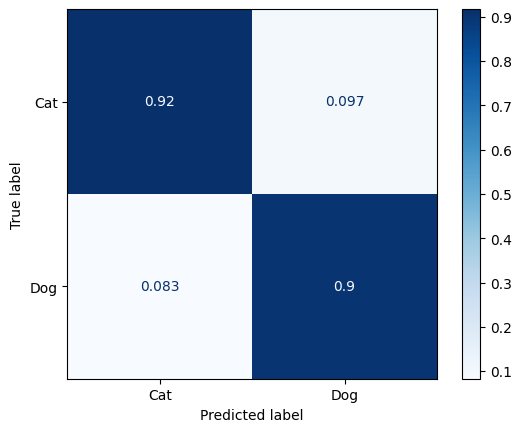

In [5]:
data = pd.read_csv(config.Features + 'data_fs300_cc20.csv')
Load_and_Train(data, 80)


* Second approach- Vanilla NN and fs500_cc20 dataset

In [6]:
# data = pd.read_csv(config.Features + 'data_fs500_cc20.csv')
# Load_and_Train(data, 80)

* 3rd approach- Vanilla NN and Random sampled dataset fs300_cc20

Epoch 1/80


c:\Users\desly\ml_lab\lab-env\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7756 - loss: 0.5044 - val_accuracy: 0.8915 - val_loss: 0.2842
Epoch 2/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8715 - loss: 0.3340 - val_accuracy: 0.8971 - val_loss: 0.2643
Epoch 3/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8819 - loss: 0.3047 - val_accuracy: 0.9051 - val_loss: 0.2430
Epoch 4/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8895 - loss: 0.2893 - val_accuracy: 0.9095 - val_loss: 0.2325
Epoch 5/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8940 - loss: 0.2763 - val_accuracy: 0.9118 - val_loss: 0.2276
Epoch 6/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8982 - loss: 0.2610 - val_accuracy: 0.9175 - val_loss: 0.2144
Epoch 7/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8993 - loss: 0.2578 - val_accuracy: 0.9193 - val_loss: 0.2083
Epoch 8/80
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9017 - loss: 0.2534 - val_accuracy: 0.9189 - val_

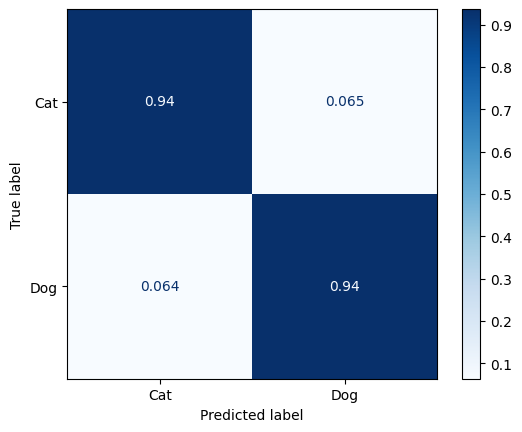

In [7]:
data = pd.read_csv(config.Features + 'Rdata_fs300_cc20.csv')
Load_and_Train(data, 80)

* Approach 3 - 2D convolutional model and fs300cc20f20 dataset

In [26]:
def min_max_normalize(feature):
    min_val = np.min(feature)
    max_val = np.max(feature)
    return (feature - min_val) / (max_val - min_val + 1e-8)  # add epsilon to avoid division by zero


In [27]:
features = np.load(config.Features + '2DRdata_fs300_cc20_f50/features.npy')  
labels = np.load(config.Features + '2DRdata_fs300_cc20_f50/labels.npy')    
# print(features[0])
X_scaled = min_max_normalize(features)
print(X_scaled[0].shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2)

(50, 20)


In [28]:

# Define input shape
input_shape = (features.shape[1], features.shape[2], 1)  # Add channel dimension for CNNs

# Reshape features for CNN: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Example model structure
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # for binary classification (cat vs dog)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



c:\Users\desly\ml_lab\lab-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# Train
model.fit(X_train, y_train, 
          epochs=200, 
          validation_data=(X_test, y_test),
          batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5493 - loss: 0.7847 - val_accuracy: 0.5632 - val_loss: 0.6893
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6004 - loss: 0.6715 - val_accuracy: 0.5632 - val_loss: 0.6853
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6015 - loss: 0.6667 - val_accuracy: 0.5632 - val_loss: 0.6737
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6002 - loss: 0.6615 - val_accuracy: 0.5632 - val_loss: 0.6630
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5975 - loss: 0.6488 - val_accuracy: 0.5632 - val_loss: 0.6482
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5937 - loss: 0.6322 - val_accuracy: 0.5632 - val_loss: 0.6268
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6108 - loss: 0.6108 - val_accuracy: 0.5632 - val_loss: 0.6042
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6178 - loss: 0.5802 - val_accuracy: 0.56

In [30]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9527 - loss: 0.1038 
Test Accuracy: 0.96


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


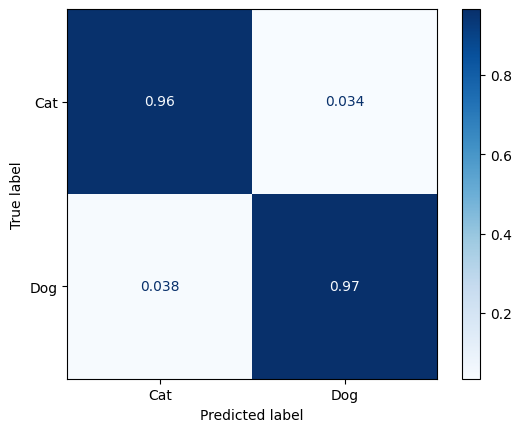

In [31]:
#Confusion Matrix
predictions = model.predict(X_test)
# print(predictions) #why are predictions between zero and 1?? Shouldnt this be binary??
# Generate confusion matrix
cm = confusion_matrix(y_test, np.round(predictions), normalize='pred')
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

* CNN without random sampling

In [32]:
features = np.load(config.Features + '2Ddata_fs300_cc20_f50/features.npy')  
labels = np.load(config.Features + '2Ddata_fs300_cc20_f50/labels.npy')    
# print(features[0])
X_scaled = min_max_normalize(features)
print(X_scaled[0].shape)
print(labels)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2)


# Define input shape
input_shape = (features.shape[1], features.shape[2], 1)  # Add channel dimension for CNNs

# Reshape features for CNN: (samples, height, width, channels)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Example model structure
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # for binary classification (cat vs dog)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])




(50, 20)
[1 1 1 ... 0 0 0]


c:\Users\desly\ml_lab\lab-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5745 - loss: 0.7028 - val_accuracy: 0.5776 - val_loss: 0.6784
Epoch 2/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6139 - loss: 0.6667 - val_accuracy: 0.5776 - val_loss: 0.6731
Epoch 3/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5985 - loss: 0.6673 - val_accuracy: 0.5776 - val_loss: 0.6658
Epoch 4/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6126 - loss: 0.6538 - val_accuracy: 0.5776 - val_loss: 0.6483
Epoch 5/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5990 - loss: 0.6377 - val_accuracy: 0.5776 - val_loss: 0.5961
Epoch 6/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6346 - loss: 0.5691 - val_accuracy: 0.8989 - val_loss: 0.4985
Epoch 7/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8354 - loss: 0.4811 - val_accuracy: 0.8773 - val_loss: 0.4015
Epoch 8/200
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8760 - loss: 0.4056 - val_accuracy: 0.

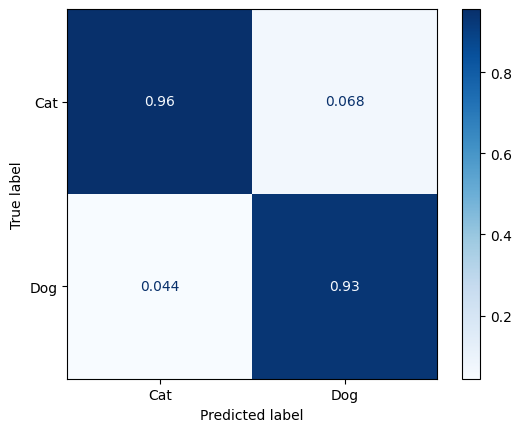

In [33]:
model.fit(X_train, y_train, 
          epochs=200, 
          validation_data=(X_test, y_test),
          batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

#Confusion Matrix
predictions = model.predict(X_test)
# print(predictions) #why are predictions between zero and 1?? Shouldnt this be binary??
# Generate confusion matrix
cm = confusion_matrix(y_test, np.round(predictions), normalize='pred')
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.show()